In [1]:


import tensorflow as tf
import numpy as np
import cv2

import matplotlib.pyplot as plt

from cell_division.nets.transfer_learning import CNN
from auxiliary.data.dataset_cell import CellDataset
from auxiliary.data.dataset_unlabeled import UnlabeledDataset
from auxiliary import values as v
from auxiliary.utils import visualizer as vis

from sklearn.metrics import classification_report, confusion_matrix
from cell_division.layers.custom_layers import (
    ExtendedLSEPooling,
    extended_w_cel_loss_soft
)

from cell_division.nets.cam import GradCAM, overlay_heatmap, CAM
from cell_division.semi_supervised import semi_supervised_learning as SSL

# GPU config
from auxiliary.gpu.gpu_tf import (
    increase_gpu_memory
)

increase_gpu_memory()
# set_gpu_allocator()

ValueError: Cannot set memory growth on device when virtual devices configured

In [2]:
img_dir = v.data_path + 'CellDivision/images_nuclei/'
img_dir_unlabeled = v.data_path + 'CellDivision/images_unlabeled/'

label_train_dir = v.data_path + 'CellDivision/undersampled/train.csv'
label_test_dir = v.data_path + 'CellDivision/undersampled/test.csv'
label_val_dir = v.data_path + 'CellDivision/undersampled/val.csv'

INPUT_SHAPE = (100, 100, 3)
BATCH_SIZE = 128

In [3]:
train_generator = CellDataset(
    img_dir, 
    label_train_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

val_generator = CellDataset(
    img_dir, 
    label_val_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

test_generator = CellDataset(
    img_dir, 
    label_test_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

unlabeled_generator = UnlabeledDataset(
    img_dir_unlabeled,
    batch_size=1,
    resize=INPUT_SHAPE[:2]
)

In [4]:
model = CNN(
    base=tf.keras.applications.VGG16,
    input_shape=INPUT_SHAPE,
    n_classes=3
)
model.build_top(activation='softmax', b_type='CAM', pooling=ExtendedLSEPooling)
model.compile(
    lr=.001,
    loss=extended_w_cel_loss_soft()
)

In [8]:
model = SSL(
    model, 
    train_generator, val_generator, test_generator,
    unlabeled_generator,
    max_iter=10,
    verbose=1
)
model.model_semi.save('../models/cellular_division_models/vgg16_semi.h5')

Iteration: 1
	Pre-training...
Epoch 1/100
4/4 [==============================] - 11s 3s/step - loss: 1.3107 - auc: 0.9154 - val_loss: 1.3372 - val_auc: 0.6774 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 11s 3s/step - loss: 0.9994 - auc: 0.9370 - val_loss: 1.3000 - val_auc: 0.7153 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 11s 3s/step - loss: 0.9707 - auc: 0.9395 - val_loss: 1.2527 - val_auc: 0.7895 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 1.1289 - auc: 0.9333
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4/4 [==============================] - 11s 3s/step - loss: 1.1289 - auc: 0.9333 - val_loss: 1.2443 - val_auc: 0.7960 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 12s 4s/step - loss: 0.7983 - auc: 0.9580 - val_loss: 1.2340 - val_auc: 0.8089 - lr: 1.0000e-04
Epoch 6/100
4/4 [==============================] - 11s 3s/step - loss: 0.8240 - auc: 0.9520 - val_loss:

In [9]:
model.model_semi.evaluate(test_generator)

1/1 [==============================] - 3s 3s/step - loss: 0.6300 - auc: 0.9461


[0.62998366355896, 0.9460909962654114]

In [10]:
pred = model.model_semi.predict(test_generator).round().astype(int)

print(
    classification_report(
        test_generator.img_labels, [test_generator.oh2class(p) for p in pred], 
        target_names=test_generator.CLASS_NAMES,
        zero_division=0
    )
)

                    precision    recall  f1-score   support

Prophase/Metaphase       0.75      0.95      0.84        42
Anaphase/Telophase       0.88      0.71      0.79        42
        Interphase       0.93      0.86      0.89        43

          accuracy                           0.84       127
         macro avg       0.85      0.84      0.84       127
      weighted avg       0.85      0.84      0.84       127



<Figure size 1200x1200 with 0 Axes>

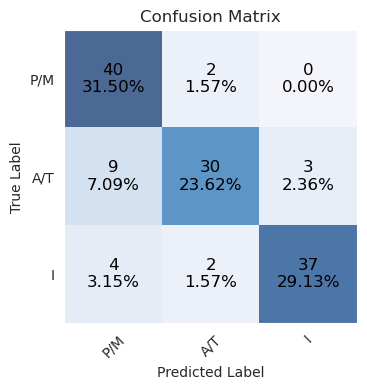

In [11]:
cf_matrix = confusion_matrix(
   test_generator.img_labels, [test_generator.oh2class(p) for p in pred]
)

plt.figure(figsize=(12, 12))
vis.plot_confusion_matrix(cf_matrix)

In [12]:
test_generator = CellDataset(
    img_dir, 
    label_test_dir, 
    batch_size=1, 
    resize=INPUT_SHAPE[:2]
)

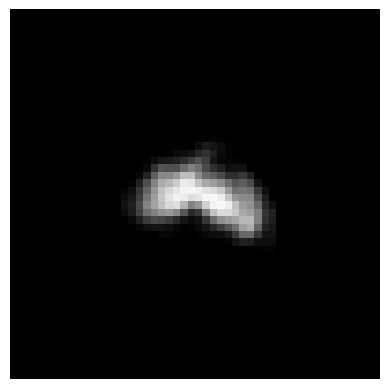

In [26]:
img_idx = 35 # 87 # 44 # 40 # 0  # 98  # 25
test_img_tf = test_generator[img_idx][0]
test_img = test_img_tf.numpy().astype(np.float32)
test_img = test_img.reshape(INPUT_SHAPE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img); plt.axis('off')
plt.show()

Real label: Prophase/Metaphase
Predicted label: Prophase/Metaphase


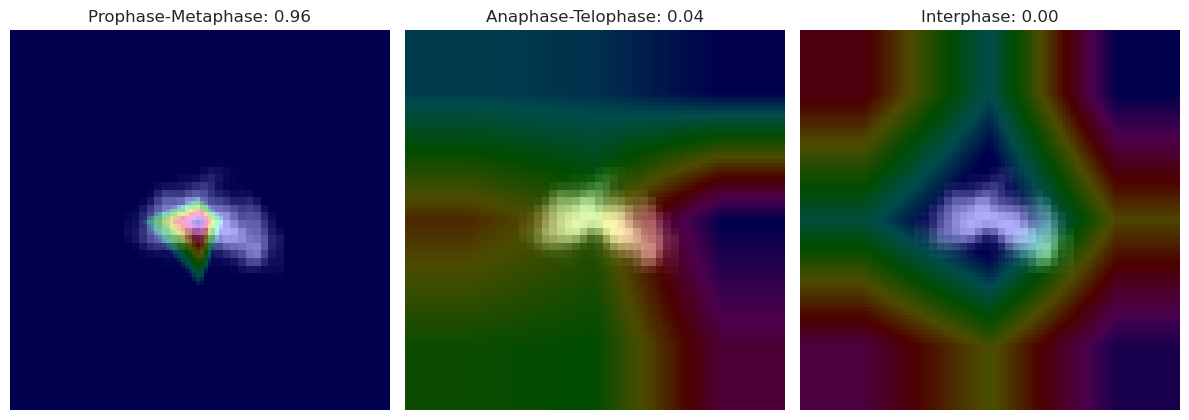

In [27]:
cam = CAM(model.model_semi)
heatmap_pm = cam.compute_heatmap(test_img_tf, class_idx=0, normalize=True)
heatmap_at = cam.compute_heatmap(test_img_tf, class_idx=1, normalize=True)
heatmap_i = cam.compute_heatmap(test_img_tf, class_idx=2, normalize=True)

pred = model.model_semi.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(overlay_heatmap(test_img, heatmap_pm, alpha=.7, colormap=cv2.COLORMAP_HSV)); plt.axis('off')
plt.title(f'Prophase-Metaphase: {pred[0][0]:.2f}')

plt.subplot(1, 3, 2)
plt.imshow(overlay_heatmap(test_img, heatmap_at, alpha=.7, colormap=cv2.COLORMAP_HSV)); plt.axis('off')
plt.title(f'Anaphase-Telophase: {pred[0][1]:.2f}')

plt.subplot(1, 3, 3)
plt.imshow(overlay_heatmap(test_img, heatmap_i, alpha=.7, colormap=cv2.COLORMAP_HSV)); plt.axis('off')
plt.title(f'Interphase: {pred[0][2]:.2f}')

plt.tight_layout()
plt.show()

Real label: Prophase/Metaphase
Predicted label: Prophase/Metaphase


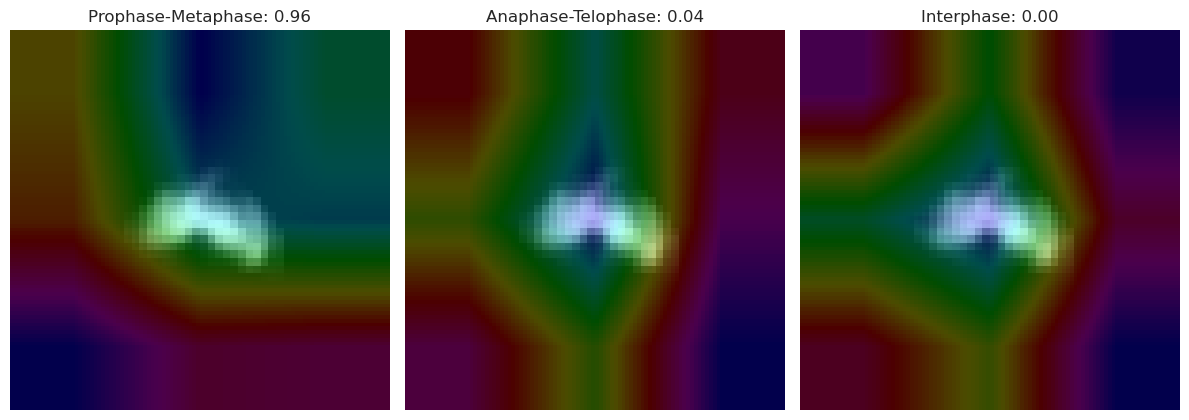

In [28]:
cam = GradCAM(model.model_semi)
heatmap_pm = cam.compute_heatmap(test_img_tf, class_idx=0)
heatmap_at = cam.compute_heatmap(test_img_tf, class_idx=1)
heatmap_i = cam.compute_heatmap(test_img_tf, class_idx=2)

pred = model.model_semi.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(overlay_heatmap(test_img, heatmap_pm, alpha=.7, colormap=cv2.COLORMAP_HSV)); plt.axis('off')
plt.title(f'Prophase-Metaphase: {pred[0][0]:.2f}')

plt.subplot(1, 3, 2)
plt.imshow(overlay_heatmap(test_img, heatmap_at, alpha=.7, colormap=cv2.COLORMAP_HSV)); plt.axis('off')
plt.title(f'Anaphase-Telophase: {pred[0][1]:.2f}')

plt.subplot(1, 3, 3)
plt.imshow(overlay_heatmap(test_img, heatmap_i, alpha=.7, colormap=cv2.COLORMAP_HSV)); plt.axis('off')
plt.title(f'Interphase: {pred[0][2]:.2f}')

plt.tight_layout()
plt.show()